In [1]:
import tensorflow as tf
print(tf.__version__)
import keras
print(keras.__version__)
# from tensorflow import keras as keras 

from numpy.random import seed
seed(123)
from tensorflow import set_random_seed
set_random_seed(123)

1.15.0
2.3.1


Using TensorFlow backend.


In [2]:
# Wczytaj dane treningowe i testowe
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

train_set = pd.read_csv('Dane/adult/adult.data', sep=", ",header = None)
test_set = pd.read_csv('Dane/adult/adult.test', sep=", ",skiprows = 1, header = None) # Make sure to skip a row for the test set

col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 
              'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
             'wage_class']
train_set.columns = col_labels
test_set.columns = col_labels

train = train_set.replace('?', np.nan).dropna()
test = test_set.replace('?', np.nan).dropna()

train_set.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  import sys


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
dataset = pd.concat([train,test])

dataset['wage_class'] = dataset.wage_class.replace({'<=50K.': 0,'<=50K':0, '>50K.':1, '>50K':1})

dataset.drop(["fnlwgt"],axis=1,inplace=True)

dataset.drop(["education"],axis=1,inplace=True)

x = dataset.groupby('native_country')["wage_class"].mean()

d = dict(pd.cut(x[x.index!=" United-States"],5,labels=range(5)))

dataset['native_country'] = dataset['native_country'].replace(d)

dataset = pd.get_dummies(dataset,drop_first=True)

train = dataset.iloc[:train.shape[0]]
test = dataset.iloc[train.shape[0]:]

X_train = train.drop("wage_class",axis=1)
y_train = train.wage_class

X_test = test.drop("wage_class",axis=1)
y_test = test.wage_class

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

print(X_train.shape)
X_test.shape

(30162, 41)


(15060, 41)

In [4]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

from keras.callbacks import History

# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.0001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * np.power(drop, np.floor((1+epoch)/epochs_drop))
    return lrate


history_Adam = History()
model = Sequential()
model.add(Dense(100,activation="sigmoid",input_shape=(X_train.shape[1],)))
model.add(Dropout(0.4))
model.add(Dense(50,activation="sigmoid"))
model.add(Dropout(0.4))
model.add(Dense(10,activation="sigmoid"))
model.add(Dropout(0.4))
model.add(Dense(1,activation="sigmoid"))
model.summary()

Adam = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss="binary_crossentropy",optimizer=Adam, metrics=["accuracy"])

lrate = LearningRateScheduler(step_decay)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1)
model.fit(X_train, y_train, validation_data= (X_test, y_test), batch_size=32,epochs=100, callbacks=[lrate, history_Adam, early_stopping])


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               4200      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                510       
_________________________________________________________________
dropout_3 (Dropout)          (None, 10)                0         
_______________________________________

30162/30162 [==============================] - 2s 53us/step - loss: 0.3680 - accuracy: 0.8328 - val_loss: 0.3393 - val_accuracy: 0.8452
Epoch 97/100
30162/30162 [==============================] - 2s 55us/step - loss: 0.3678 - accuracy: 0.8320 - val_loss: 0.3393 - val_accuracy: 0.8452
Epoch 98/100
30162/30162 [==============================] - 2s 57us/step - loss: 0.3713 - accuracy: 0.8297 - val_loss: 0.3393 - val_accuracy: 0.8452
Epoch 99/100
30162/30162 [==============================] - 2s 53us/step - loss: 0.3665 - accuracy: 0.8330 - val_loss: 0.3393 - val_accuracy: 0.8452
Epoch 100/100
30162/30162 [==============================] - 2s 55us/step - loss: 0.3660 - accuracy: 0.8332 - val_loss: 0.3393 - val_accuracy: 0.8452


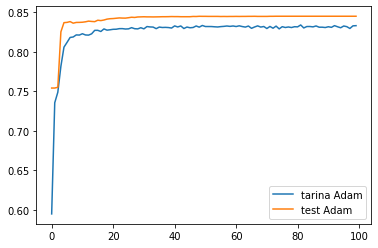

In [5]:
plt.plot(history_Adam.history['accuracy'], label = "tarina Adam")
plt.plot(history_Adam.history['val_accuracy'], label = "test Adam")


plt.legend()
plt.show()

# Zad.
Do do modelu 
```python
model.add(Dropout(0.8))
```
po każdej warstwie.

Zwizualizuj wyniki dla obu modeli.

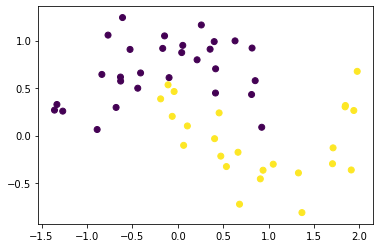

In [6]:
from sklearn.datasets import make_moons
# generate 2d classification dataset
X, y = make_moons(n_samples=100, noise=0.2, random_state=5)
# split into train and test
# n_train = 30
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.70, random_state=2)

n_train=53
X_train, X_test = X[:n_train, :], X[n_train:, :]
y_train, y_test = y[:n_train], y[n_train:]

plt.scatter(X_train[:,0],X_train[:,1], c=y_train)
plt.show()

In [7]:
from keras.callbacks import History


history_Adam = History()
model = Sequential()
model.add(Dense(1000,activation="relu",input_shape=(X_train.shape[1],)))
model.add(Dense(500,activation="sigmoid"))
model.add(Dense(200,activation="sigmoid"))
model.add(Dense(1,activation="sigmoid"))
model.summary()

model.compile(loss="binary_crossentropy",optimizer="adam", metrics=["accuracy"])

lrate = LearningRateScheduler(step_decay)
model.fit(X_train, y_train, validation_data= (X_test, y_test), epochs=1000, callbacks=[history_Adam])


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1000)              3000      
_________________________________________________________________
dense_6 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_7 (Dense)              (None, 200)               100200    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 201       
Total params: 603,901
Trainable params: 603,901
Non-trainable params: 0
_________________________________________________________________
Train on 53 samples, validate on 47 samples
Epoch 1/1000
53/53 [==============================] - 0s 4ms/step - loss: 0.6911 - accuracy: 0.5660 - val_loss: 0.6709 - val_accuracy: 0.5532
Epoch 2/1000
53/53 [==============================] - 0s 529

53/53 [==============================] - 0s 491us/step - loss: 0.0720 - accuracy: 0.9811 - val_loss: 0.2357 - val_accuracy: 0.9149
Epoch 108/1000
53/53 [==============================] - 0s 510us/step - loss: 0.0706 - accuracy: 0.9811 - val_loss: 0.2194 - val_accuracy: 0.8936
Epoch 109/1000
53/53 [==============================] - 0s 491us/step - loss: 0.0697 - accuracy: 0.9811 - val_loss: 0.2157 - val_accuracy: 0.8936
Epoch 110/1000
53/53 [==============================] - 0s 510us/step - loss: 0.0674 - accuracy: 0.9811 - val_loss: 0.2165 - val_accuracy: 0.9149
Epoch 111/1000
53/53 [==============================] - ETA: 0s - loss: 0.0687 - accuracy: 0.96 - 0s 510us/step - loss: 0.0641 - accuracy: 0.9811 - val_loss: 0.2251 - val_accuracy: 0.9149
Epoch 112/1000
53/53 [==============================] - 0s 510us/step - loss: 0.0634 - accuracy: 0.9811 - val_loss: 0.2288 - val_accuracy: 0.9149
Epoch 113/1000
53/53 [==============================] - 0s 397us/step - loss: 0.0596 - accuracy: 

Epoch 163/1000
53/53 [==============================] - 0s 295us/step - loss: 0.0198 - accuracy: 1.0000 - val_loss: 0.1735 - val_accuracy: 0.9149
Epoch 164/1000
53/53 [==============================] - 0s 590us/step - loss: 0.0196 - accuracy: 1.0000 - val_loss: 0.1791 - val_accuracy: 0.9149
Epoch 165/1000
53/53 [==============================] - 0s 716us/step - loss: 0.0187 - accuracy: 1.0000 - val_loss: 0.1800 - val_accuracy: 0.9149
Epoch 166/1000
53/53 [==============================] - 0s 585us/step - loss: 0.0184 - accuracy: 1.0000 - val_loss: 0.1808 - val_accuracy: 0.9149
Epoch 167/1000
53/53 [==============================] - 0s 384us/step - loss: 0.0180 - accuracy: 1.0000 - val_loss: 0.1823 - val_accuracy: 0.9149
Epoch 168/1000
53/53 [==============================] - 0s 590us/step - loss: 0.0177 - accuracy: 1.0000 - val_loss: 0.1835 - val_accuracy: 0.9149
Epoch 169/1000
53/53 [==============================] - 0s 589us/step - loss: 0.0175 - accuracy: 1.0000 - val_loss: 0.1868 -

53/53 [==============================] - 0s 510us/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 0.2107 - val_accuracy: 0.9149
Epoch 276/1000
53/53 [==============================] - 0s 510us/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 0.2115 - val_accuracy: 0.9149
Epoch 277/1000
53/53 [==============================] - 0s 491us/step - loss: 0.0050 - accuracy: 1.0000 - val_loss: 0.2120 - val_accuracy: 0.9149
Epoch 278/1000
53/53 [==============================] - 0s 510us/step - loss: 0.0050 - accuracy: 1.0000 - val_loss: 0.2134 - val_accuracy: 0.9149
Epoch 279/1000
53/53 [==============================] - 0s 510us/step - loss: 0.0051 - accuracy: 1.0000 - val_loss: 0.2140 - val_accuracy: 0.9149
Epoch 280/1000
53/53 [==============================] - 0s 491us/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.2141 - val_accuracy: 0.9149
Epoch 281/1000
53/53 [==============================] - 0s 534us/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.2143 - val_accuracy: 

Epoch 387/1000
53/53 [==============================] - 0s 590us/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.2403 - val_accuracy: 0.9149
Epoch 388/1000
53/53 [==============================] - 0s 590us/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.2408 - val_accuracy: 0.9149
Epoch 389/1000
53/53 [==============================] - 0s 590us/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.2413 - val_accuracy: 0.9149
Epoch 390/1000
53/53 [==============================] - 0s 590us/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.2405 - val_accuracy: 0.9149
Epoch 391/1000
53/53 [==============================] - 0s 295us/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.2412 - val_accuracy: 0.9149
Epoch 392/1000
53/53 [==============================] - 0s 295us/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.2418 - val_accuracy: 0.9149
Epoch 393/1000
53/53 [==============================] - 0s 590us/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.2424 -

Epoch 499/1000
53/53 [==============================] - 0s 510us/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.2763 - val_accuracy: 0.9149
Epoch 500/1000
53/53 [==============================] - 0s 491us/step - loss: 9.8706e-04 - accuracy: 1.0000 - val_loss: 0.2771 - val_accuracy: 0.9149
Epoch 501/1000
53/53 [==============================] - 0s 491us/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.2772 - val_accuracy: 0.9149
Epoch 502/1000
53/53 [==============================] - 0s 472us/step - loss: 9.6970e-04 - accuracy: 1.0000 - val_loss: 0.2759 - val_accuracy: 0.9149
Epoch 503/1000
53/53 [==============================] - 0s 491us/step - loss: 9.5447e-04 - accuracy: 1.0000 - val_loss: 0.2746 - val_accuracy: 0.9149
Epoch 504/1000
53/53 [==============================] - 0s 491us/step - loss: 9.6565e-04 - accuracy: 1.0000 - val_loss: 0.2743 - val_accuracy: 0.9149
Epoch 505/1000
53/53 [==============================] - 0s 491us/step - loss: 0.0010 - accuracy: 1.0000 - va

Epoch 608/1000
53/53 [==============================] - 0s 295us/step - loss: 5.7761e-04 - accuracy: 1.0000 - val_loss: 0.3043 - val_accuracy: 0.9149
Epoch 609/1000
53/53 [==============================] - 0s 295us/step - loss: 5.6628e-04 - accuracy: 1.0000 - val_loss: 0.3067 - val_accuracy: 0.9149
Epoch 610/1000
53/53 [==============================] - 0s 885us/step - loss: 5.9052e-04 - accuracy: 1.0000 - val_loss: 0.3091 - val_accuracy: 0.9149
Epoch 611/1000
53/53 [==============================] - 0s 585us/step - loss: 6.2084e-04 - accuracy: 1.0000 - val_loss: 0.3101 - val_accuracy: 0.9149
Epoch 612/1000
53/53 [==============================] - 0s 604us/step - loss: 5.9529e-04 - accuracy: 1.0000 - val_loss: 0.3087 - val_accuracy: 0.9149
Epoch 613/1000
53/53 [==============================] - 0s 623us/step - loss: 5.5963e-04 - accuracy: 1.0000 - val_loss: 0.3059 - val_accuracy: 0.9149
Epoch 614/1000
53/53 [==============================] - 0s 604us/step - loss: 5.6357e-04 - accuracy:

Epoch 717/1000
53/53 [==============================] - 0s 513us/step - loss: 3.7651e-04 - accuracy: 1.0000 - val_loss: 0.3313 - val_accuracy: 0.9149
Epoch 718/1000
53/53 [==============================] - 0s 404us/step - loss: 3.7337e-04 - accuracy: 1.0000 - val_loss: 0.3295 - val_accuracy: 0.9149
Epoch 719/1000
53/53 [==============================] - ETA: 0s - loss: 5.3739e-04 - accuracy: 1.00 - 0s 720us/step - loss: 3.7255e-04 - accuracy: 1.0000 - val_loss: 0.3283 - val_accuracy: 0.9149
Epoch 720/1000
53/53 [==============================] - 0s 491us/step - loss: 3.7868e-04 - accuracy: 1.0000 - val_loss: 0.3278 - val_accuracy: 0.9149
Epoch 721/1000
53/53 [==============================] - 0s 529us/step - loss: 3.7796e-04 - accuracy: 1.0000 - val_loss: 0.3283 - val_accuracy: 0.9149
Epoch 722/1000
53/53 [==============================] - 0s 529us/step - loss: 3.7371e-04 - accuracy: 1.0000 - val_loss: 0.3293 - val_accuracy: 0.9149
Epoch 723/1000
53/53 [==============================] 

53/53 [==============================] - 0s 491us/step - loss: 2.6651e-04 - accuracy: 1.0000 - val_loss: 0.3534 - val_accuracy: 0.9149
Epoch 826/1000
53/53 [==============================] - 0s 491us/step - loss: 2.5963e-04 - accuracy: 1.0000 - val_loss: 0.3537 - val_accuracy: 0.9149
Epoch 827/1000
53/53 [==============================] - 0s 491us/step - loss: 2.6327e-04 - accuracy: 1.0000 - val_loss: 0.3541 - val_accuracy: 0.9149
Epoch 828/1000
53/53 [==============================] - 0s 491us/step - loss: 2.6506e-04 - accuracy: 1.0000 - val_loss: 0.3536 - val_accuracy: 0.9149
Epoch 829/1000
53/53 [==============================] - 0s 491us/step - loss: 2.6117e-04 - accuracy: 1.0000 - val_loss: 0.3540 - val_accuracy: 0.9149
Epoch 830/1000
53/53 [==============================] - 0s 491us/step - loss: 2.5610e-04 - accuracy: 1.0000 - val_loss: 0.3537 - val_accuracy: 0.9149
Epoch 831/1000
53/53 [==============================] - 0s 510us/step - loss: 2.6253e-04 - accuracy: 1.0000 - val_l

Epoch 880/1000
53/53 [==============================] - 0s 369us/step - loss: 2.2416e-04 - accuracy: 1.0000 - val_loss: 0.3613 - val_accuracy: 0.9149
Epoch 881/1000
53/53 [==============================] - 0s 590us/step - loss: 2.2048e-04 - accuracy: 1.0000 - val_loss: 0.3625 - val_accuracy: 0.9149
Epoch 882/1000
53/53 [==============================] - 0s 589us/step - loss: 2.1899e-04 - accuracy: 1.0000 - val_loss: 0.3646 - val_accuracy: 0.9149
Epoch 883/1000
53/53 [==============================] - 0s 295us/step - loss: 2.1915e-04 - accuracy: 1.0000 - val_loss: 0.3659 - val_accuracy: 0.9149
Epoch 884/1000
53/53 [==============================] - 0s 590us/step - loss: 2.2651e-04 - accuracy: 1.0000 - val_loss: 0.3669 - val_accuracy: 0.9149
Epoch 885/1000
53/53 [==============================] - 0s 590us/step - loss: 2.2106e-04 - accuracy: 1.0000 - val_loss: 0.3664 - val_accuracy: 0.9149
Epoch 886/1000
53/53 [==============================] - 0s 590us/step - loss: 2.1848e-04 - accuracy:

Epoch 989/1000
53/53 [==============================] - 0s 491us/step - loss: 1.6295e-04 - accuracy: 1.0000 - val_loss: 0.3815 - val_accuracy: 0.9149
Epoch 990/1000
53/53 [==============================] - 0s 510us/step - loss: 1.6259e-04 - accuracy: 1.0000 - val_loss: 0.3810 - val_accuracy: 0.9149
Epoch 991/1000
53/53 [==============================] - 0s 529us/step - loss: 1.6911e-04 - accuracy: 1.0000 - val_loss: 0.3802 - val_accuracy: 0.9149
Epoch 992/1000
53/53 [==============================] - 0s 491us/step - loss: 1.6743e-04 - accuracy: 1.0000 - val_loss: 0.3805 - val_accuracy: 0.9149
Epoch 993/1000
53/53 [==============================] - 0s 491us/step - loss: 1.6430e-04 - accuracy: 1.0000 - val_loss: 0.3817 - val_accuracy: 0.9149
Epoch 994/1000
53/53 [==============================] - 0s 491us/step - loss: 1.6149e-04 - accuracy: 1.0000 - val_loss: 0.3830 - val_accuracy: 0.9149
Epoch 995/1000
53/53 [==============================] - 0s 491us/step - loss: 1.5969e-04 - accuracy:

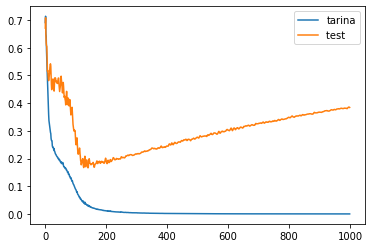

In [8]:
plt.plot(history_Adam.history['loss'], label = "tarina")
plt.plot(history_Adam.history['val_loss'], label = "test ")


plt.legend()
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


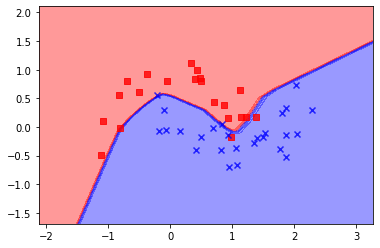

In [9]:
from help_plot import plot_decision_regions
plot_decision_regions(X_test, y_test, model)
plt.show()

In [10]:
from keras.callbacks import History

# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.0001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * np.power(drop, np.floor((1+epoch)/epochs_drop))
    return lrate


history_Adam_1 = History()
model = Sequential()
model.add(Dense(1000,activation="relu",input_shape=(X_train.shape[1],)))
model.add(Dropout(0.8))
model.add(Dense(500,activation="sigmoid"))
model.add(Dropout(0.8))
model.add(Dense(200,activation="sigmoid"))
model.add(Dropout(0.8))
model.add(Dense(1,activation="sigmoid"))
model.summary()

model.compile(loss="binary_crossentropy",optimizer="adam", metrics=["accuracy"])

model.fit(X_train, y_train, validation_data= (X_test, y_test), epochs=1000, callbacks=[history_Adam_1])


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 1000)              3000      
_________________________________________________________________
dropout_4 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 500)               500500    
_________________________________________________________________
dropout_5 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 200)               100200    
_________________________________________________________________
dropout_6 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                

53/53 [==============================] - 0s 623us/step - loss: 0.3068 - accuracy: 0.8679 - val_loss: 0.5224 - val_accuracy: 0.7872
Epoch 102/1000
53/53 [==============================] - 0s 566us/step - loss: 0.3077 - accuracy: 0.9057 - val_loss: 0.5182 - val_accuracy: 0.7872
Epoch 103/1000
53/53 [==============================] - 0s 566us/step - loss: 0.3517 - accuracy: 0.8491 - val_loss: 0.5133 - val_accuracy: 0.7872
Epoch 104/1000
53/53 [==============================] - 0s 548us/step - loss: 0.3029 - accuracy: 0.8868 - val_loss: 0.5108 - val_accuracy: 0.7872
Epoch 105/1000
53/53 [==============================] - 0s 548us/step - loss: 0.3076 - accuracy: 0.9057 - val_loss: 0.5107 - val_accuracy: 0.7872
Epoch 106/1000
53/53 [==============================] - 0s 529us/step - loss: 0.2959 - accuracy: 0.9057 - val_loss: 0.5107 - val_accuracy: 0.7872
Epoch 107/1000
53/53 [==============================] - 0s 529us/step - loss: 0.2669 - accuracy: 0.8491 - val_loss: 0.5139 - val_accuracy: 

53/53 [==============================] - 0s 548us/step - loss: 0.2434 - accuracy: 0.9057 - val_loss: 0.4660 - val_accuracy: 0.8085
Epoch 213/1000
53/53 [==============================] - 0s 529us/step - loss: 0.2389 - accuracy: 0.9057 - val_loss: 0.4646 - val_accuracy: 0.8085
Epoch 214/1000
53/53 [==============================] - 0s 529us/step - loss: 0.2522 - accuracy: 0.8868 - val_loss: 0.4638 - val_accuracy: 0.8085
Epoch 215/1000
53/53 [==============================] - 0s 548us/step - loss: 0.2522 - accuracy: 0.8679 - val_loss: 0.4641 - val_accuracy: 0.8085
Epoch 216/1000
53/53 [==============================] - ETA: 0s - loss: 0.1965 - accuracy: 0.87 - 0s 548us/step - loss: 0.1871 - accuracy: 0.9057 - val_loss: 0.4634 - val_accuracy: 0.8085
Epoch 217/1000
53/53 [==============================] - 0s 548us/step - loss: 0.2612 - accuracy: 0.8679 - val_loss: 0.4641 - val_accuracy: 0.8085
Epoch 218/1000
53/53 [==============================] - 0s 604us/step - loss: 0.1947 - accuracy: 

Epoch 268/1000
53/53 [==============================] - 0s 590us/step - loss: 0.2149 - accuracy: 0.9057 - val_loss: 0.4545 - val_accuracy: 0.8085
Epoch 269/1000
53/53 [==============================] - 0s 590us/step - loss: 0.1930 - accuracy: 0.9057 - val_loss: 0.4559 - val_accuracy: 0.8085
Epoch 270/1000
53/53 [==============================] - 0s 590us/step - loss: 0.3012 - accuracy: 0.8679 - val_loss: 0.4563 - val_accuracy: 0.8085
Epoch 271/1000
53/53 [==============================] - 0s 590us/step - loss: 0.2456 - accuracy: 0.9057 - val_loss: 0.4582 - val_accuracy: 0.8085
Epoch 272/1000
53/53 [==============================] - 0s 634us/step - loss: 0.2324 - accuracy: 0.8679 - val_loss: 0.4619 - val_accuracy: 0.8085
Epoch 273/1000
53/53 [==============================] - 0s 590us/step - loss: 0.2372 - accuracy: 0.9057 - val_loss: 0.4661 - val_accuracy: 0.8085
Epoch 274/1000
53/53 [==============================] - 0s 590us/step - loss: 0.2845 - accuracy: 0.8868 - val_loss: 0.4688 -

53/53 [==============================] - 0s 590us/step - loss: 0.1485 - accuracy: 0.9434 - val_loss: 0.4339 - val_accuracy: 0.8085
Epoch 381/1000
53/53 [==============================] - 0s 590us/step - loss: 0.1753 - accuracy: 0.9434 - val_loss: 0.4335 - val_accuracy: 0.8085
Epoch 382/1000
53/53 [==============================] - 0s 590us/step - loss: 0.1637 - accuracy: 0.9623 - val_loss: 0.4312 - val_accuracy: 0.8085
Epoch 383/1000
53/53 [==============================] - 0s 590us/step - loss: 0.2265 - accuracy: 0.9057 - val_loss: 0.4307 - val_accuracy: 0.8085
Epoch 384/1000
53/53 [==============================] - 0s 590us/step - loss: 0.1828 - accuracy: 0.9245 - val_loss: 0.4307 - val_accuracy: 0.8085
Epoch 385/1000
53/53 [==============================] - 0s 590us/step - loss: 0.1688 - accuracy: 0.9245 - val_loss: 0.4304 - val_accuracy: 0.8085
Epoch 386/1000
53/53 [==============================] - 0s 590us/step - loss: 0.1962 - accuracy: 0.9434 - val_loss: 0.4312 - val_accuracy: 

53/53 [==============================] - 0s 566us/step - loss: 0.1154 - accuracy: 0.9623 - val_loss: 0.4153 - val_accuracy: 0.8511
Epoch 493/1000
53/53 [==============================] - 0s 585us/step - loss: 0.1346 - accuracy: 0.9623 - val_loss: 0.4156 - val_accuracy: 0.8511
Epoch 494/1000
53/53 [==============================] - 0s 585us/step - loss: 0.1592 - accuracy: 0.9434 - val_loss: 0.4156 - val_accuracy: 0.8511
Epoch 495/1000
53/53 [==============================] - 0s 566us/step - loss: 0.2075 - accuracy: 0.9057 - val_loss: 0.4137 - val_accuracy: 0.8511
Epoch 496/1000
53/53 [==============================] - 0s 585us/step - loss: 0.1648 - accuracy: 0.9057 - val_loss: 0.4130 - val_accuracy: 0.8511
Epoch 497/1000
53/53 [==============================] - 0s 548us/step - loss: 0.1448 - accuracy: 0.9245 - val_loss: 0.4102 - val_accuracy: 0.8511
Epoch 498/1000
53/53 [==============================] - 0s 548us/step - loss: 0.1514 - accuracy: 0.9434 - val_loss: 0.4081 - val_accuracy: 

53/53 [==============================] - 0s 566us/step - loss: 0.0939 - accuracy: 0.9811 - val_loss: 0.3211 - val_accuracy: 0.8723
Epoch 605/1000
53/53 [==============================] - 0s 585us/step - loss: 0.1332 - accuracy: 0.9434 - val_loss: 0.3213 - val_accuracy: 0.8723
Epoch 606/1000
53/53 [==============================] - 0s 585us/step - loss: 0.1413 - accuracy: 0.9245 - val_loss: 0.3241 - val_accuracy: 0.8723
Epoch 607/1000
53/53 [==============================] - 0s 566us/step - loss: 0.1277 - accuracy: 0.9811 - val_loss: 0.3254 - val_accuracy: 0.8723
Epoch 608/1000
53/53 [==============================] - 0s 566us/step - loss: 0.1290 - accuracy: 0.9623 - val_loss: 0.3260 - val_accuracy: 0.8723
Epoch 609/1000
53/53 [==============================] - 0s 566us/step - loss: 0.0925 - accuracy: 0.9623 - val_loss: 0.3268 - val_accuracy: 0.8723
Epoch 610/1000
53/53 [==============================] - 0s 585us/step - loss: 0.1258 - accuracy: 0.9434 - val_loss: 0.3274 - val_accuracy: 

53/53 [==============================] - 0s 604us/step - loss: 0.0799 - accuracy: 0.9623 - val_loss: 0.2790 - val_accuracy: 0.8723
Epoch 717/1000
53/53 [==============================] - 0s 623us/step - loss: 0.1468 - accuracy: 0.9245 - val_loss: 0.2788 - val_accuracy: 0.8723
Epoch 718/1000
53/53 [==============================] - 0s 604us/step - loss: 0.0593 - accuracy: 1.0000 - val_loss: 0.2796 - val_accuracy: 0.8723
Epoch 719/1000
53/53 [==============================] - 0s 604us/step - loss: 0.1353 - accuracy: 0.9434 - val_loss: 0.2845 - val_accuracy: 0.8723
Epoch 720/1000
53/53 [==============================] - 0s 623us/step - loss: 0.0590 - accuracy: 0.9623 - val_loss: 0.2879 - val_accuracy: 0.8723
Epoch 721/1000
53/53 [==============================] - 0s 585us/step - loss: 0.1293 - accuracy: 0.9434 - val_loss: 0.2909 - val_accuracy: 0.8936
Epoch 722/1000
53/53 [==============================] - 0s 585us/step - loss: 0.1771 - accuracy: 0.9434 - val_loss: 0.2935 - val_accuracy: 

53/53 [==============================] - 0s 774us/step - loss: 0.0383 - accuracy: 0.9811 - val_loss: 0.2848 - val_accuracy: 0.8936
Epoch 829/1000
53/53 [==============================] - 0s 642us/step - loss: 0.0938 - accuracy: 0.9434 - val_loss: 0.2890 - val_accuracy: 0.8936
Epoch 830/1000
53/53 [==============================] - 0s 604us/step - loss: 0.0564 - accuracy: 0.9811 - val_loss: 0.2904 - val_accuracy: 0.8936
Epoch 831/1000
53/53 [==============================] - 0s 566us/step - loss: 0.1250 - accuracy: 0.9623 - val_loss: 0.2885 - val_accuracy: 0.8936
Epoch 832/1000
53/53 [==============================] - 0s 566us/step - loss: 0.0318 - accuracy: 0.9811 - val_loss: 0.2823 - val_accuracy: 0.8936
Epoch 833/1000
53/53 [==============================] - 0s 566us/step - loss: 0.0573 - accuracy: 0.9623 - val_loss: 0.2766 - val_accuracy: 0.8936
Epoch 834/1000
53/53 [==============================] - 0s 585us/step - loss: 0.0775 - accuracy: 0.9623 - val_loss: 0.2713 - val_accuracy: 

Epoch 940/1000
53/53 [==============================] - 0s 455us/step - loss: 0.0319 - accuracy: 0.9811 - val_loss: 0.2557 - val_accuracy: 0.9149
Epoch 941/1000
53/53 [==============================] - 0s 590us/step - loss: 0.1033 - accuracy: 0.9811 - val_loss: 0.2562 - val_accuracy: 0.9149
Epoch 942/1000
53/53 [==============================] - 0s 589us/step - loss: 0.0510 - accuracy: 0.9811 - val_loss: 0.2543 - val_accuracy: 0.8936
Epoch 943/1000
53/53 [==============================] - 0s 590us/step - loss: 0.0495 - accuracy: 0.9811 - val_loss: 0.2496 - val_accuracy: 0.8936
Epoch 944/1000
53/53 [==============================] - 0s 590us/step - loss: 0.0521 - accuracy: 1.0000 - val_loss: 0.2462 - val_accuracy: 0.8936
Epoch 945/1000
53/53 [==============================] - 0s 590us/step - loss: 0.0202 - accuracy: 1.0000 - val_loss: 0.2435 - val_accuracy: 0.8936
Epoch 946/1000
53/53 [==============================] - 0s 590us/step - loss: 0.0830 - accuracy: 0.9623 - val_loss: 0.2396 -

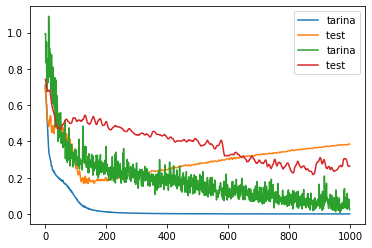

In [11]:
plt.plot(history_Adam.history['loss'], label = "tarina")
plt.plot(history_Adam.history['val_loss'], label = "test ")

plt.plot(history_Adam_1.history['loss'], label = "tarina")
plt.plot(history_Adam_1.history['val_loss'], label = "test ")

plt.legend()
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


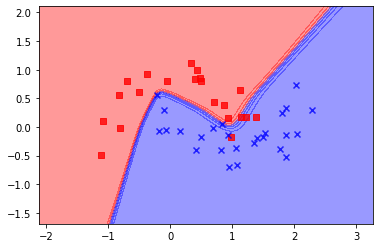

In [12]:
from help_plot import plot_decision_regions
plot_decision_regions(X_test, y_test, model)
plt.show()

# Regularyzacja

# Zad.
Do do modelu 
* 
```python
model.add(Dense( ... , activity_regularizer=l1(0.00001)))
```
* 
```python
model.add(Dense( ... , activity_regularizer=l1(0.0001)))
```

* 
```python
model.add(Dense( ... , activity_regularizer=l2(0.00001)))
```
* 
```python
model.add(Dense( ... , activity_regularizer=l2(0.0001)))
```

w każdej warstwie.

Zwizualizuj wyniki dla obu modeli.

In [13]:
from keras.callbacks import History
from keras.regularizers import l1


history_Adam_2 = History()
model = Sequential()
model.add(Dense(1000,activation="relu",input_shape=(X_train.shape[1],), activity_regularizer=l1(0.00001)))
model.add(Dense(500,activation="sigmoid", activity_regularizer=l1(0.00001)))
model.add(Dense(200,activation="sigmoid", activity_regularizer=l1(0.00001)))
model.add(Dense(1,activation="sigmoid"))
model.summary()

model.compile(loss="binary_crossentropy",optimizer="adam", metrics=["accuracy"])

model.fit(X_train, y_train, validation_data= (X_test, y_test), epochs=1000, callbacks=[history_Adam_2])


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 1000)              3000      
_________________________________________________________________
dense_14 (Dense)             (None, 500)               500500    
_________________________________________________________________
dense_15 (Dense)             (None, 200)               100200    
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 201       
Total params: 603,901
Trainable params: 603,901
Non-trainable params: 0
_________________________________________________________________
Train on 53 samples, validate on 47 samples
Epoch 1/1000
53/53 [==============================] - 0s 5ms/step - loss: 0.8459 - accuracy: 0.5472 - val_loss: 0.8222 - val_accuracy: 0.4468
Epoch 2/1000
53/53 [==============================] - 0s 585

Epoch 51/1000
53/53 [==============================] - 0s 585us/step - loss: 0.2701 - accuracy: 0.9245 - val_loss: 0.5264 - val_accuracy: 0.8298
Epoch 52/1000
53/53 [==============================] - 0s 566us/step - loss: 0.2667 - accuracy: 0.9434 - val_loss: 0.5145 - val_accuracy: 0.8298
Epoch 53/1000
53/53 [==============================] - 0s 604us/step - loss: 0.2639 - accuracy: 0.9245 - val_loss: 0.5009 - val_accuracy: 0.8298
Epoch 54/1000
53/53 [==============================] - 0s 548us/step - loss: 0.2613 - accuracy: 0.9245 - val_loss: 0.4945 - val_accuracy: 0.8298
Epoch 55/1000
53/53 [==============================] - 0s 566us/step - loss: 0.2601 - accuracy: 0.9245 - val_loss: 0.4905 - val_accuracy: 0.8298
Epoch 56/1000
53/53 [==============================] - 0s 566us/step - loss: 0.2571 - accuracy: 0.9245 - val_loss: 0.4945 - val_accuracy: 0.8298
Epoch 57/1000
53/53 [==============================] - 0s 529us/step - loss: 0.2555 - accuracy: 0.9245 - val_loss: 0.5061 - val_ac

53/53 [==============================] - 0s 604us/step - loss: 0.0918 - accuracy: 1.0000 - val_loss: 0.2400 - val_accuracy: 0.8936
Epoch 164/1000
53/53 [==============================] - 0s 642us/step - loss: 0.0911 - accuracy: 1.0000 - val_loss: 0.2414 - val_accuracy: 0.8936
Epoch 165/1000
53/53 [==============================] - 0s 623us/step - loss: 0.0907 - accuracy: 1.0000 - val_loss: 0.2419 - val_accuracy: 0.8936
Epoch 166/1000
53/53 [==============================] - 0s 604us/step - loss: 0.0902 - accuracy: 1.0000 - val_loss: 0.2411 - val_accuracy: 0.8936
Epoch 167/1000
53/53 [==============================] - 0s 736us/step - loss: 0.0898 - accuracy: 1.0000 - val_loss: 0.2412 - val_accuracy: 0.8936
Epoch 168/1000
53/53 [==============================] - 0s 963us/step - loss: 0.0898 - accuracy: 1.0000 - val_loss: 0.2426 - val_accuracy: 0.8936
Epoch 169/1000
53/53 [==============================] - 0s 1ms/step - loss: 0.0891 - accuracy: 1.0000 - val_loss: 0.2471 - val_accuracy: 0.

53/53 [==============================] - 0s 473us/step - loss: 0.0655 - accuracy: 1.0000 - val_loss: 0.2904 - val_accuracy: 0.8936
Epoch 276/1000
53/53 [==============================] - 0s 692us/step - loss: 0.0650 - accuracy: 1.0000 - val_loss: 0.2888 - val_accuracy: 0.8936
Epoch 277/1000
53/53 [==============================] - 0s 548us/step - loss: 0.0651 - accuracy: 1.0000 - val_loss: 0.2870 - val_accuracy: 0.8936
Epoch 278/1000
53/53 [==============================] - ETA: 0s - loss: 0.0764 - accuracy: 1.00 - 0s 529us/step - loss: 0.0650 - accuracy: 1.0000 - val_loss: 0.2863 - val_accuracy: 0.8936
Epoch 279/1000
53/53 [==============================] - 0s 566us/step - loss: 0.0648 - accuracy: 1.0000 - val_loss: 0.2863 - val_accuracy: 0.8936
Epoch 280/1000
53/53 [==============================] - 0s 548us/step - loss: 0.0645 - accuracy: 1.0000 - val_loss: 0.2856 - val_accuracy: 0.8936
Epoch 281/1000
53/53 [==============================] - 0s 529us/step - loss: 0.0647 - accuracy: 

53/53 [==============================] - 0s 548us/step - loss: 0.0543 - accuracy: 1.0000 - val_loss: 0.3118 - val_accuracy: 0.8936
Epoch 386/1000
53/53 [==============================] - 0s 314us/step - loss: 0.0536 - accuracy: 1.0000 - val_loss: 0.3097 - val_accuracy: 0.8936
Epoch 387/1000
53/53 [==============================] - 0s 590us/step - loss: 0.0540 - accuracy: 1.0000 - val_loss: 0.3088 - val_accuracy: 0.8936
Epoch 388/1000
53/53 [==============================] - 0s 825us/step - loss: 0.0544 - accuracy: 1.0000 - val_loss: 0.3088 - val_accuracy: 0.8936
Epoch 389/1000
53/53 [==============================] - 0s 566us/step - loss: 0.0538 - accuracy: 1.0000 - val_loss: 0.3093 - val_accuracy: 0.8936
Epoch 390/1000
53/53 [==============================] - 0s 529us/step - loss: 0.0535 - accuracy: 1.0000 - val_loss: 0.3099 - val_accuracy: 0.8936
Epoch 391/1000
53/53 [==============================] - 0s 548us/step - loss: 0.0534 - accuracy: 1.0000 - val_loss: 0.3105 - val_accuracy: 

53/53 [==============================] - 0s 492us/step - loss: 0.0468 - accuracy: 1.0000 - val_loss: 0.2959 - val_accuracy: 0.8936
Epoch 498/1000
53/53 [==============================] - 0s 590us/step - loss: 0.0470 - accuracy: 1.0000 - val_loss: 0.2959 - val_accuracy: 0.9149
Epoch 499/1000
53/53 [==============================] - 0s 590us/step - loss: 0.0469 - accuracy: 1.0000 - val_loss: 0.2952 - val_accuracy: 0.9149
Epoch 500/1000
53/53 [==============================] - 0s 590us/step - loss: 0.0468 - accuracy: 1.0000 - val_loss: 0.2936 - val_accuracy: 0.9149
Epoch 501/1000
53/53 [==============================] - 0s 590us/step - loss: 0.0467 - accuracy: 1.0000 - val_loss: 0.2918 - val_accuracy: 0.8936
Epoch 502/1000
53/53 [==============================] - 0s 590us/step - loss: 0.0470 - accuracy: 1.0000 - val_loss: 0.2906 - val_accuracy: 0.8936
Epoch 503/1000
53/53 [==============================] - 0s 589us/step - loss: 0.0468 - accuracy: 1.0000 - val_loss: 0.2907 - val_accuracy: 

Epoch 609/1000
53/53 [==============================] - 0s 295us/step - loss: 0.0416 - accuracy: 1.0000 - val_loss: 0.2710 - val_accuracy: 0.9149
Epoch 610/1000
53/53 [==============================] - 0s 295us/step - loss: 0.0417 - accuracy: 1.0000 - val_loss: 0.2703 - val_accuracy: 0.9149
Epoch 611/1000
53/53 [==============================] - 0s 590us/step - loss: 0.0414 - accuracy: 1.0000 - val_loss: 0.2686 - val_accuracy: 0.9149
Epoch 612/1000
53/53 [==============================] - 0s 590us/step - loss: 0.0409 - accuracy: 1.0000 - val_loss: 0.2670 - val_accuracy: 0.9149
Epoch 613/1000
53/53 [==============================] - 0s 590us/step - loss: 0.0413 - accuracy: 1.0000 - val_loss: 0.2667 - val_accuracy: 0.9149
Epoch 614/1000
53/53 [==============================] - 0s 590us/step - loss: 0.0410 - accuracy: 1.0000 - val_loss: 0.2671 - val_accuracy: 0.9149
Epoch 615/1000
53/53 [==============================] - 0s 590us/step - loss: 0.0410 - accuracy: 1.0000 - val_loss: 0.2669 -

Epoch 665/1000
53/53 [==============================] - 0s 590us/step - loss: 0.0392 - accuracy: 1.0000 - val_loss: 0.2584 - val_accuracy: 0.9149
Epoch 666/1000
53/53 [==============================] - 0s 590us/step - loss: 0.0391 - accuracy: 1.0000 - val_loss: 0.2581 - val_accuracy: 0.9149
Epoch 667/1000
53/53 [==============================] - 0s 590us/step - loss: 0.0391 - accuracy: 1.0000 - val_loss: 0.2575 - val_accuracy: 0.9149
Epoch 668/1000
53/53 [==============================] - 0s 590us/step - loss: 0.0388 - accuracy: 1.0000 - val_loss: 0.2569 - val_accuracy: 0.9149
Epoch 669/1000
53/53 [==============================] - 0s 590us/step - loss: 0.0390 - accuracy: 1.0000 - val_loss: 0.2564 - val_accuracy: 0.9149
Epoch 670/1000
53/53 [==============================] - 0s 590us/step - loss: 0.0390 - accuracy: 1.0000 - val_loss: 0.2573 - val_accuracy: 0.9149
Epoch 671/1000
53/53 [==============================] - 0s 590us/step - loss: 0.0388 - accuracy: 1.0000 - val_loss: 0.2582 -

Epoch 721/1000
53/53 [==============================] - 0s 548us/step - loss: 0.0371 - accuracy: 1.0000 - val_loss: 0.2456 - val_accuracy: 0.9149
Epoch 722/1000
53/53 [==============================] - 0s 510us/step - loss: 0.0364 - accuracy: 1.0000 - val_loss: 0.2447 - val_accuracy: 0.9149
Epoch 723/1000
53/53 [==============================] - 0s 529us/step - loss: 0.0367 - accuracy: 1.0000 - val_loss: 0.2439 - val_accuracy: 0.9149
Epoch 724/1000
53/53 [==============================] - 0s 529us/step - loss: 0.0369 - accuracy: 1.0000 - val_loss: 0.2447 - val_accuracy: 0.9149
Epoch 725/1000
53/53 [==============================] - 0s 529us/step - loss: 0.0366 - accuracy: 1.0000 - val_loss: 0.2448 - val_accuracy: 0.9149
Epoch 726/1000
53/53 [==============================] - 0s 623us/step - loss: 0.0367 - accuracy: 1.0000 - val_loss: 0.2450 - val_accuracy: 0.9149
Epoch 727/1000
53/53 [==============================] - 0s 604us/step - loss: 0.0366 - accuracy: 1.0000 - val_loss: 0.2451 -

53/53 [==============================] - 0s 295us/step - loss: 0.0332 - accuracy: 1.0000 - val_loss: 0.2359 - val_accuracy: 0.9149
Epoch 833/1000
53/53 [==============================] - 0s 590us/step - loss: 0.0331 - accuracy: 1.0000 - val_loss: 0.2372 - val_accuracy: 0.9149
Epoch 834/1000
53/53 [==============================] - 0s 776us/step - loss: 0.0330 - accuracy: 1.0000 - val_loss: 0.2371 - val_accuracy: 0.9149
Epoch 835/1000
53/53 [==============================] - 0s 510us/step - loss: 0.0331 - accuracy: 1.0000 - val_loss: 0.2369 - val_accuracy: 0.9149
Epoch 836/1000
53/53 [==============================] - 0s 246us/step - loss: 0.0331 - accuracy: 1.0000 - val_loss: 0.2373 - val_accuracy: 0.9149
Epoch 837/1000
53/53 [==============================] - 0s 295us/step - loss: 0.0329 - accuracy: 1.0000 - val_loss: 0.2366 - val_accuracy: 0.9149
Epoch 838/1000
53/53 [==============================] - 0s 590us/step - loss: 0.0330 - accuracy: 1.0000 - val_loss: 0.2354 - val_accuracy: 

53/53 [==============================] - 0s 491us/step - loss: 0.0298 - accuracy: 1.0000 - val_loss: 0.2244 - val_accuracy: 0.9362
Epoch 945/1000
53/53 [==============================] - 0s 548us/step - loss: 0.0297 - accuracy: 1.0000 - val_loss: 0.2239 - val_accuracy: 0.9149
Epoch 946/1000
53/53 [==============================] - 0s 548us/step - loss: 0.0299 - accuracy: 1.0000 - val_loss: 0.2246 - val_accuracy: 0.9149
Epoch 947/1000
53/53 [==============================] - 0s 491us/step - loss: 0.0296 - accuracy: 1.0000 - val_loss: 0.2253 - val_accuracy: 0.9149
Epoch 948/1000
53/53 [==============================] - 0s 529us/step - loss: 0.0296 - accuracy: 1.0000 - val_loss: 0.2256 - val_accuracy: 0.9149
Epoch 949/1000
53/53 [==============================] - 0s 529us/step - loss: 0.0296 - accuracy: 1.0000 - val_loss: 0.2259 - val_accuracy: 0.9149
Epoch 950/1000
53/53 [==============================] - 0s 510us/step - loss: 0.0297 - accuracy: 1.0000 - val_loss: 0.2250 - val_accuracy: 

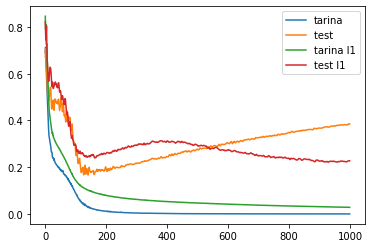

In [14]:
plt.plot(history_Adam.history['loss'], label = "tarina")
plt.plot(history_Adam.history['val_loss'], label = "test ")

# plt.plot(history_Adam_1.history['loss'], label = "tarina dropout")
# plt.plot(history_Adam_1.history['val_loss'], label = "test dropout")

plt.plot(history_Adam_2.history['loss'], label = "tarina l1")
plt.plot(history_Adam_2.history['val_loss'], label = "test l1")

plt.legend()
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


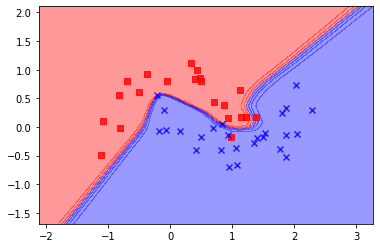

In [15]:
from help_plot import plot_decision_regions
plot_decision_regions(X_test, y_test, model)
plt.show()